In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%time

df = pd.read_csv('HIGGS_6M.csv', header=None)
df.shape

Wall time: 41.1 s


(6000000, 29)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


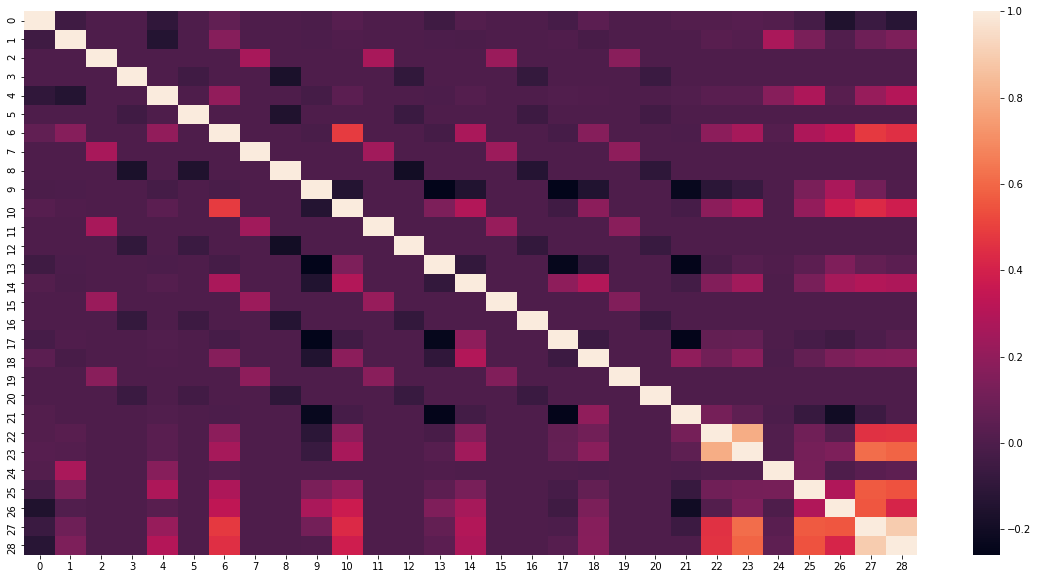

In [4]:
fig = plt.figure(figsize=(20,10))

sns.heatmap(df.corr())
plt.show()

**We notice that features 27 and 28 are highly correlated. Likewise, features 22 and 23 are highly correlated as well.**

In [5]:
cols = list(df.columns)
cols.remove(0)

In [6]:
TEST_SIZE = 50000
train = df.iloc[:-TEST_SIZE]
test = df.iloc[-TEST_SIZE:]

X = train[cols]
y = train[0]

X_test = test[cols]
y_test = test[0]

X.shape, y.shape, X_test.shape, y_test.shape

((5950000, 28), (5950000,), (50000, 28), (50000,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=0)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4760000, 28), (4760000,), (1190000, 28), (1190000,))

### **Basic Classifiers**

Let's look at classification performance for a set of basic classifiers from **Logistic Regression** to **ensemble model (boosting) - Light Gradient Boosting Machine.**

Boosting is a technique which improves the **performance of individual weak learners by improving predictive power with every subsequent iteration.** 

However, gradient boosting machines can be **computationally costly as there are lot of gradients to be optimized**. LGBM is an technique which enables **leaf-wise tree growth** as opposed to GBMs which perform **level-wise tree growth**, and because of this **LGBMs are faster**.

In [9]:
%%time

clf1 = LogisticRegression()
clf2 = LinearDiscriminantAnalysis()
clf3 = LGBMClassifier()

SCORES={}
for (label, clf) in [('LR',clf1), ('LDA',clf2), ('LGBM',clf3)]:

    clf.fit(X, y)
    y_pred = clf.predict(X_test)

    SCORES[label] = roc_auc_score(y_test, y_pred)

CPU times: user 6min 37s, sys: 19 s, total: 6min 55s
Wall time: 3min 59s


In [10]:
results = pd.DataFrame(SCORES.values(), index=SCORES.keys(), columns=['AUROC'])
results

,AUROC
LR,0.634145
LDA,0.633155
LGBM,0.733136


**LGBM performs better than Logistic Regression and Linear Discriminant Analysis**

### Neural Network

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
hidden_dim = 10
output_dim = 1

class MLP(Model):
    def __init__(self, hidden_dim, output_dim):
        super(MLP, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = tf.keras.Sequential(layers.Dense(hidden_dim, activation='relu'))
        self.fc2 = tf.keras.Sequential(layers.Dense(output_dim, activation='sigmoid'))
        
    def call(self, x):
        
        hidden = self.fc1(x)
        output = self.fc2(hidden)

        return output
    
model = MLP(hidden_dim, output_dim)

In [13]:
lrop = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 3)
estop = EarlyStopping(monitor='val_loss', patience = 5)

model.compile(optimizer = 'adam', loss = losses.BinaryCrossentropy(), metrics = metrics.AUC())

In [14]:
history = model.fit(X_train, y_train, epochs = 10, shuffle = True, 
          validation_data = (X_val, y_val), callbacks = [lrop, estop])

Epoch 1/10
148750/148750 [==============================] - 408s 3ms/step - loss: 0.6088 - auc: 0.7250 - val_loss: 0.5746 - val_auc: 0.7706
Epoch 2/10
148750/148750 [==============================] - 405s 3ms/step - loss: 0.5741 - auc: 0.7690 - val_loss: 0.5720 - val_auc: 0.7724
Epoch 3/10
148750/148750 [==============================] - 406s 3ms/step - loss: 0.5712 - auc: 0.7720 - val_loss: 0.5694 - val_auc: 0.7737
Epoch 4/10
148750/148750 [==============================] - 405s 3ms/step - loss: 0.5706 - auc: 0.7724 - val_loss: 0.5705 - val_auc: 0.7746
Epoch 5/10
148750/148750 [==============================] - 403s 3ms/step - loss: 0.5700 - auc: 0.7730 - val_loss: 0.5703 - val_auc: 0.7751
Epoch 6/10
148750/148750 [==============================] - 407s 3ms/step - loss: 0.5694 - auc: 0.7737 - val_loss: 0.5695 - val_auc: 0.7738
Epoch 7/10
148750/148750 [==============================] - 412s 3ms/step - loss: 0.5661 - auc: 0.7770 - val_loss: 0.5653 - val_auc: 0.7780
Epoch 8/10
148750/14

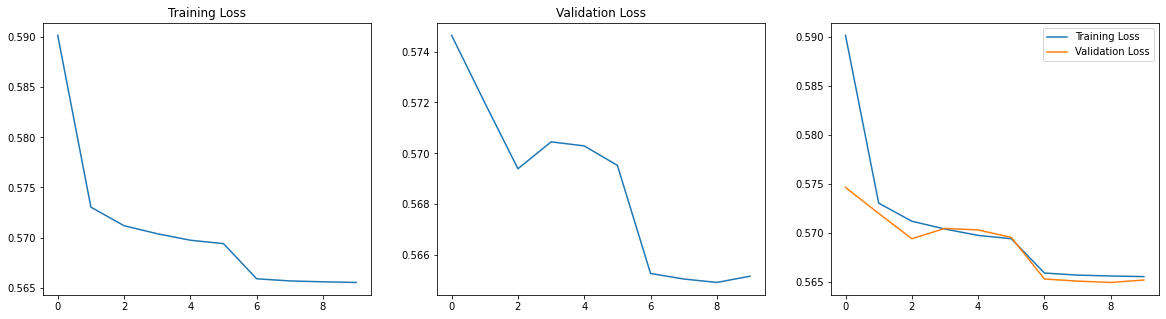

In [15]:
fig=plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(history.history["loss"], label="Training Loss")
plt.title('Training Loss')

plt.subplot(132)
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Validation Loss')

plt.subplot(133)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

As we notice that **the training and validation loss are close to each other**, this implies that the model is **not overfitting**. 

Also, in such cases of **large sizes of training data, chances of overfitting reduce** as the model **cannot learn too much to learn the noise in data as well**.

In [16]:
y_score = model.call(X_test.values).numpy()
y_pred = (y_score>=0.5)*1

SCORES['NN'] = roc_auc_score(y_test, y_pred)

In [17]:
results = pd.DataFrame(SCORES.values(), index=SCORES.keys(), columns=['AUROC'])
results

,AUROC
LR,0.634145
LDA,0.633155
LGBM,0.733136
NN,0.706686


Since we have got best results with **LGBM Classifier**, we will plot ROC Curve for it.

In [8]:
clf = LGBMClassifier()
clf.fit(X, y)

y_train_pred = clf.predict(X)
y_test_pred = clf.predict(X_test)

y_train_score=clf.predict_proba(X)[:,1]
y_test_score=clf.predict_proba(X_test)[:,1]

In [8]:
def find_outcome(actual_label, predicted_label):
    
    if (actual_label==predicted_label):
        if (actual_label == 1):
            return 'TP'
        else:
            return 'TN'
        
    else:
        if (actual_label == 1):
            return 'FN'
        else:
            return 'FP'
        
def calculate_roc_metrics(y_test, y_score, threshold):
    
    y_pred = (y_score>=threshold)*1
    outcomes = np.array(list(map(lambda x,y: find_outcome(x,y), y_test, y_pred)))
    
    tp = sum(outcomes=='TP')
    tn = sum(outcomes=='TN')
    fp = sum(outcomes=='FP')
    fn = sum(outcomes=='FN')
    
    if tp==0:
        tpr=0
    else:
        tpr = tp/(tp+fn)
    
    if fp==0:
        fpr = 0
    else:
        fpr = fp/(fp+tn)
    
    return fpr, tpr        

In [9]:
%%time

N_DATAPOINTS = 10
thresholds = np.linspace(0, 1, N_DATAPOINTS)

train_roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y.values, y_train_score, x), thresholds)))
test_roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y_test.values, y_test_score, x), thresholds)))

train_fpr = train_roc_metrics[:,0]
train_tpr = train_roc_metrics[:,1]

test_fpr = test_roc_metrics[:,0]
test_tpr = test_roc_metrics[:,1]

Wall time: 7min 41s


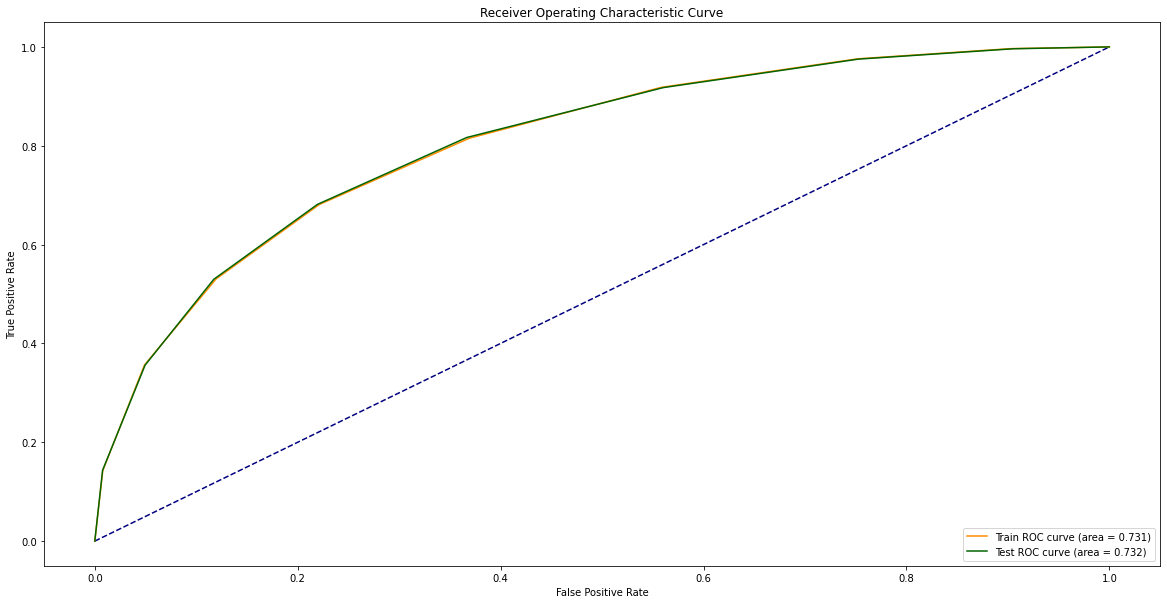

In [11]:
fig = plt.figure(figsize = (20,10))

train_roc_auc = roc_auc_score(y, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(train_fpr, train_tpr, color='darkorange', label='Train ROC curve (area = %0.3f)' % train_roc_auc)
plt.plot(test_fpr, test_tpr, color='darkgreen', label='Test ROC curve (area = %0.3f)' % test_roc_auc)
plt.legend(loc="lower right")
plt.show()

One way to check for overfitting through ROC curves is by **plotting Training and Testing ROC Curves and understanding the gap between the two**. If the **gap is large**, there are chances that the **model might be overfitted**.

As we can see that **there isn't much difference between the ROC curves for training data and testing data**, we can conclude that the model is **not overfitting**.

### Saving the model

In [9]:
import pickle

with open('clf_task1.pkl', 'wb') as f:
    pickle.dump(clf, f)